# Preâmbulo

In [5]:
%load_ext autoreload
%autoreload 2
%pip install numpy scipy
import numpy as np
from dual_simplex import dual_simplex, _dual_feasible_basis, _is_dual_feasible
from gommory_cuts import cutting_planes
from scipy.optimize import linprog
from IPython.display import display, HTML, Markdown, Latex, SVG, Math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


![](https://i.imgur.com/aAmyuEt.png)

In [6]:
A = np.array([
    [3, 5, 4, 1]
])
b = np.array([
    14
])
c = -np.array([
    6, 9, 7, 0
])

m, n = A.shape

I = list(
    range(n - m,  n)
)

A_aux, b_aux, c_aux, I_aux, J_aux = _dual_feasible_basis(A, b, c, I)
z_star, x_star, w_star, I_star, iters, solution_type, steps = dual_simplex(A_aux, b_aux, c_aux, I_aux)

x_star_repr = f'[ {', \\ '.join([str(f'{x:.2f}') for x in x_star])} ]'
x_star_repr_restricted = f'[ {', \\ '.join([str(f'{x:.2f}') for x in x_star[:3]])} ]'
I_star_repr = f'[ {', \\ '.join([str(f'{i:d}') for i in I_star])} ]'

markdown_content = f'''
## 1. a)

**Solução ótima para o problema relaxado:**

\\begin{{align}}
    z^{{*}} &= {-z_star:.2f} \\\\
    x^{{*}} &= {x_star_repr} \\\\
    I^{{*}} &= {I_star_repr}
\\end{{align}}

A variável $x_4 = {x_star[-1]:.2f}$ é obtida pela adição de um corte big M no método dual simplex para transformar a base inicial como dual factível.
No caso, a solução ótima do problema é dada apenas por $ x^{{*}} = {x_star_repr_restricted} $, com $ z^{{*}} = {-z_star:.2f}$.
'''
display(
    Markdown(markdown_content)
)


## 1. a)

**Solução ótima para o problema relaxado:**

\begin{align}
    z^{*} &= 28.00 \\
    x^{*} &= [ 4.67, \ 0.00, \ 0.00, \ 0.00, \ 14331.33 ] \\
    I^{*} &= [ 0, \ 4 ]
\end{align}

A variável $x_4 = 14331.33$ é obtida pela adição de um corte big M no método dual simplex para transformar a base inicial como dual factível.
No caso, a solução ótima do problema é dada apenas por $ x^{*} = [ 4.67, \ 0.00, \ 0.00 ] $, com $ z^{*} = 28.00$.


## 1. b)

In [7]:
def display_cut(coefs, type = 'gommory'):
    """
    mostra o corte efetuado no formato LaTeX.
    Assume que:
    - os n primeiros coeficientes são variáveis (x_0 a x_{n-1}),
    - o penúltimo é a variável de excesso (omitida),
    - o último é o lado direito (rhs).
    """
    terms = []
    n = len(coefs) - 2  # número de variáveis "reais"

    for i in range(n):
        coef = coefs[i]
        if coef == 0:
            continue

        abs_coef = abs(coef)
        var_str = f"x_{i}" if abs_coef == 1 else f"{abs_coef:.2f} x_{i}"

        if not terms:
            # primeiro termo
            term = f"-{var_str}" if coef < 0 else f"{var_str}"
        else:
            sign = "+" if coef > 0 else "-"
            term = f"{sign} {var_str}"

        terms.append(term)

    rhs = coefs[-1]

    if type == 'gommory':
        ineq = '\\geq'
    elif type == 'cover':
        ineq = '\\leq' 
    else:
        raise Exception('Invalid Cut')

    if not terms:
        return f"& 0 {ineq} {rhs:.2f}"

    lhs = " ".join(terms)
    return f"&{lhs} {ineq} {rhs:.2f} "

z_star, x_star, I_star, iters, solution_type, steps = cutting_planes(
    A,
    b,
    c,
    I
)
cuts = '$$\\begin{align}'
for step in steps:
    if steps[step]['cut_performed']:
        cuts += display_cut(steps[step]['cut_row']) + '\\\\\n'
cuts += '\\end{align}$$'
Markdown(cuts)

$$\begin{align}&0.33 x_1 + 0.67 x_2 + 0.67 x_3 \geq 0.33 \\
&0.50 x_1 + x_3 + 0.50 x_5 \geq 0.50 \\
\end{align}$$

In [5]:
print(x_star)
print(-z_star)

[3.00000000e+00 1.00000000e+00 9.09494702e-13 0.00000000e+00
 1.43320000e+04 0.00000000e+00 0.00000000e+00]
26.99999999999909


![](https://i.imgur.com/AdkLHpH.png)

## 2. a)

**Coberturas mínimas:**

$$
\begin{align}
    & 5 x\_1 + 7 x\_ 3 > 9 \\
    & 4 x\_2 + 7 x\_ 3 > 9 \\
    & 5 x\_1 + 4 x\_ 2 + 2 x\_4 > 9
\end{align}
$$

**Cortes de cobertura mínimos:**
$$
\begin{align}
    & x\_1 + x\_3 \leq 1 \\
    & x\_2 + x\_3 \leq 1 \\
    & x\_1 + x\_2 + x\_4 \leq 2
\end{align}
$$

In [51]:
from cover_cuts import _sequential_lifting

weights = np.array([5, 4, 7, 2])
knapsack_capacity = 9

extended_cuts = r'''$$
\begin{align}
'''
# primeira cobertura minima: x_0 + x_2 <= 1
minimal_covers = np.array([
    [1, 0, 1, 0],
    [0, 1, 1, 0],
    [1, 1, 0, 1]
])
for y in minimal_covers:
    beta = np.sum(y) - 1
    extended_y = _sequential_lifting(
        y,
        beta,
        weights,
        knapsack_capacity
    )
    cut = display_cut(
        np.concatenate(
            (extended_y, [1, beta])
        ),
        type = 'cover'
    )
    extended_cuts += cut
    extended_cuts += r'\\' + '\n'
extended_cuts += r'''\end{align}
$$
'''
markdown_text = '''
Fazendo o lifting dos cortes propostos:

'''
markdown_text += extended_cuts
markdown_text += '''
É possível observar que ao menos o último corte pôde ser extendido e fortalecido pela adição da variável $x_2$.
'''
Markdown(markdown_text)


Fazendo o lifting dos cortes propostos:

$$
\begin{align}
&x_0 + x_2 \leq 1.00 \\
&x_1 + x_2 \leq 1.00 \\
&x_0 + x_1 + x_2 + x_3 \leq 2.00 \\
\end{align}
$$

É possível observar que ao menos o último corte pôde ser extendido e fortalecido pela adição da variável $x_2$.


## 2. b)

In [52]:
A = np.array([
    [5, 4, 7, 2, 1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 1]
])
b = np.array([
    9,
    1,
    1,
    1,
    1
])
c = -np.array([
    6, 4, 5, 3, 0, 0, 0, 0, 0
])

m, n = A.shape

I = list(
    range(n - m,  n)
)

A_aux, b_aux, c_aux, I_aux, J_aux = _dual_feasible_basis(A, b, c, I)
z_star, x_star, w_star, I_star, iters, solution_type, steps = dual_simplex(A_aux, b_aux, c_aux, I_aux)

x_star_repr = f'[ {', \\ '.join([str(f'{x:.2f}') for x in x_star])} ]'
x_star_repr_restricted = f'[ {', \\ '.join([str(f'{x:.2f}') for x in x_star[:4]])} ]'
I_star_repr = f'[ {', \\ '.join([str(f'{i:d}') for i in I_star])} ]'

markdown_content = f'''
## 2. b)

**Solução ótima para o problema relaxado:**

\\begin{{align}}
    z^{{*}} &= {-z_star:.2f} \\\\
    x^{{*}} &= {x_star_repr} \\\\
    I^{{*}} &= {I_star_repr}
\\end{{align}}

A variável $x_9 = {x_star[-1]:.2f}$ é obtida pela adição de um corte big M no método dual simplex para transformar a base inicial como dual factível.
No caso, a solução ótima do problema é dada apenas por $ x^{{*}} = {x_star_repr_restricted} $, com $ z^{{*}} = {-z_star:.2f}$.
'''
display(
    Markdown(markdown_content)
)


## 2. b)

**Solução ótima para o problema relaxado:**

\begin{align}
    z^{*} &= 11.00 \\
    x^{*} &= [ 1.00, \ 0.50, \ 0.00, \ 1.00, \ 0.00, \ 0.00, \ 0.50, \ 1.00, \ 0.00, \ 9213.50 ] \\
    I^{*} &= [ 3, \ 1, \ 6, \ 7, \ 9, \ 0 ]
\end{align}

A variável $x_9 = 9213.50$ é obtida pela adição de um corte big M no método dual simplex para transformar a base inicial como dual factível.
No caso, a solução ótima do problema é dada apenas por $ x^{*} = [ 1.00, \ 0.50, \ 0.00, \ 1.00 ] $, com $ z^{*} = 11.00$.


## 2. c)

Os cortes de cobertura que eliminam a solução fracional do problema relaxado são: 

$$
\begin{align}
    & x_0 + x_1 + x_2 + x_3 \leq 2.00 \\
    & x_0 + x_2 \leq 1.00
\end{align}
$$

Adicionando estes cortes e resolvendo o problema, temos por solução:

In [58]:
A = np.array([
    [5, 4, 7, 2, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
])
A = A[:-1,:-1]
b = np.array([
    9,
    1,
    1,
    1,
    1,
    2,
    1
])
b = b[:-1]
c = -np.array([
    6, 4, 5, 3, 0, 0, 0, 0, 0, 0, 0
])
c = c[:-1]

m, n = A.shape

I = list(
    range(n - m,  n)
)

A_aux, b_aux, c_aux, I_aux, J_aux = _dual_feasible_basis(A, b, c, I)
z_star, x_star, w_star, I_star, iters, solution_type, steps = dual_simplex(A_aux, b_aux, c_aux, I_aux)

x_star_repr = f'[ {', \\ '.join([str(f'{x:.2f}') for x in x_star])} ]'
x_star_repr_restricted = f'[ {', \\ '.join([str(f'{x:.2f}') for x in x_star[:4]])} ]'
I_star_repr = f'[ {', \\ '.join([str(f'{i:d}') for i in I_star])} ]'

markdown_content = f'''
## 2. c)

**Solução ótima para o problema com os cortes de cobertura efetuados:**

\\begin{{align}}
    z^{{*}} &= {-z_star:.2f} \\\\
    x^{{*}} &= {x_star_repr} \\\\
    I^{{*}} &= {I_star_repr}
\\end{{align}}

A variável $x_{{10}} = {x_star[-1]:.2f}$ é obtida pela adição de um corte big M no método dual simplex para transformar a base inicial como dual factível.
No caso, a solução ótima do problema é dada apenas por $ x^{{*}} = {x_star_repr_restricted} $, com $ z^{{*}} = {-z_star:.2f}$.
'''
display(
    Markdown(markdown_content)
)


## 2. c)

**Solução ótima para o problema com os cortes de cobertura efetuados:**

\begin{align}
    z^{*} &= 10.00 \\
    x^{*} &= [ 1.00, \ 1.00, \ 0.00, \ 0.00, \ 0.00, \ 0.00, \ 0.00, \ 1.00, \ 1.00, \ 0.00, \ 9214.00 ] \\
    I^{*} &= [ 3, \ 1, \ 6, \ 7, \ 10, \ 8, \ 0 ]
\end{align}

A variável $x_{10} = 9214.00$ é obtida pela adição de um corte big M no método dual simplex para transformar a base inicial como dual factível.
No caso, a solução ótima do problema é dada apenas por $ x^{*} = [ 1.00, \ 1.00, \ 0.00, \ 0.00 ] $, com $ z^{*} = 10.00$.


## Exercício 3

In [55]:
from cover_cuts import _sequential_lifting
weights = np.array([
    9, 8, 6, 6, 5
])
knapsack_capacity = 14

extended_cuts = r'''$$
\begin{align}
'''
minimal_covers = np.array([
    [1, 1, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 0, 0]
])
for y in minimal_covers:
    beta = np.sum(y) - 1
    extended_y = _sequential_lifting(
        y,
        beta,
        weights,
        knapsack_capacity
    )
    cut = display_cut(
        np.concatenate(
            (extended_y, [1, beta])
        ),
        type = 'cover'
    )
    extended_cuts += cut
    extended_cuts += r'\\' + '\n'
extended_cuts += r'''\end{align}
$$
'''
markdown_text = '''
Fazendo o lifting dos cortes propostos temos:

'''
markdown_text += extended_cuts
Markdown(markdown_text)


Fazendo o lifting dos cortes propostos temos:

$$
\begin{align}
&x_0 + x_1 \leq 1.00 \\
&x_1 + x_2 + x_3 + x_4 \leq 2.00 \\
&x_0 + x_1 + x_2 + x_3 + x_4 \leq 2.00 \\
\end{align}
$$


## Exercício 4

![](https://i.imgur.com/DfGtJj8.png)

In [8]:
A = np.array([
    [-1, 2, 1, 0, 0],
    [ 1, 1, 0, 1, 0],
    [ 1, 3, 0, 0, 1]
])
b = np.array([
    4,
    6,
    9
])
c = -np.array([
    2, 3, 0, 0, 0
])

m, n = A.shape

I = list(
    range(n - m,  n)
)

A_aux, b_aux, c_aux, I_aux, J_aux = _dual_feasible_basis(A, b, c, I)
z_star, x_star, w_star, I_star, iters, solution_type, steps = dual_simplex(A_aux, b_aux, c_aux, I_aux)

x_star_repr = f'[ {', \\ '.join([str(f'{x:.2f}') for x in x_star])} ]'
x_star_repr_restricted = f'[ {', \\ '.join([str(f'{x:.2f}') for x in x_star[:5]])} ]'
I_star_repr = f'[ {', \\ '.join([str(f'{i:d}') for i in I_star])} ]'

markdown_content = f'''
## Exercício 4 Resolução

**Solução ótima para o problema relaxado:**

\\begin{{align}}
    z^{{*}} &= {-z_star:.2f} \\\\
    x^{{*}} &= {x_star_repr} \\\\
    I^{{*}} &= {I_star_repr}
\\end{{align}}

A variável $x_6 = {x_star[-1]:.2f}$ é obtida pela adição de um corte big M no método dual simplex para transformar a base inicial como dual factível.
No caso, a solução ótima do problema é dada apenas por $ x^{{*}} = {x_star_repr_restricted} $, com $ z^{{*}} = {-z_star:.2f}$.
'''
display(
    Markdown(markdown_content)
)


## Exercício 4 Resolução

**Solução ótima para o problema relaxado:**

\begin{align}
    z^{*} &= 13.50 \\
    x^{*} &= [ 4.50, \ 1.50, \ 5.50, \ 0.00, \ 0.00, \ 9210.00 ] \\
    I^{*} &= [ 2, \ 5, \ 0, \ 1 ]
\end{align}

A variável $x_6 = 9210.00$ é obtida pela adição de um corte big M no método dual simplex para transformar a base inicial como dual factível.
No caso, a solução ótima do problema é dada apenas por $ x^{*} = [ 4.50, \ 1.50, \ 5.50, \ 0.00, \ 0.00 ] $, com $ z^{*} = 13.50$.


In [17]:
z_star, x_star, I_star, iters, solution_type, steps = cutting_planes(
    A,
    b,
    c,
    I
)
cuts = '$$\\begin{align}\n'
for step in steps:
    if steps[step]['cut_performed']:
        cuts += display_cut(steps[step]['cut_row']) + '\\\\\n'
cuts += '\\end{align}$$'
Markdown(cuts)

$$\begin{align}
&0.50 x_3 + 0.50 x_4 \geq 0.50 \\
\end{align}$$

Apenas a adição do corte 

$$\begin{align}
& x_4 + x_5 \geq 1 \\
\end{align}$$

É suficiente para garantir uma solução ótima e inteira para o problema do tipo $X^{*} = [5,\ 1,\ 7,\ 0,\ 1]$ com valor ótimo $Z^{*} = 13$

Como $x_4 = 6 - x_1 - x_2 $ e $ x_5 = 9 - x_1 - 3 x_2 $, substituindo estes valores na restrição do corte, temos que:

$$
\begin{align}
-2 x_1 - 4 x_2 + 15 &\geq 1 \therefore \\
-2 x_1 - 4 x_2 &\geq -14 \therefore \\
2 x_1 + 4 x_2 &\leq 14
\end{align}
$$

Para construir o politopo temos as retas de suas fronteiras:

1. $ y = \frac{x}{2} + 2 $
2. $ y = - x + 6 $
3. $ y = - \frac{x}{3} + 3 $
4. $ y = - \frac{x}{2} + \frac{7}{2} $

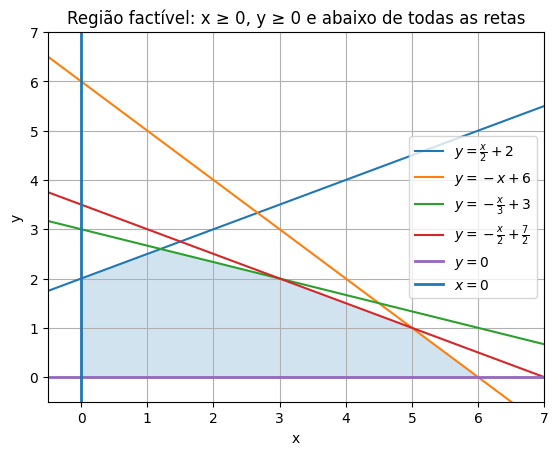

In [25]:
import matplotlib.pyplot as plt

# Define the x-range
x = np.linspace(-1, 8, 200)

# Define the lines
y1 = x / 2 + 2
y2 = -x + 6
y3 = -x / 3 + 3
y4 = -x / 2 + 7 / 2
y5 = 0 * x

# Plot
plt.figure()
plt.plot(x, y1, label=r"$y=\frac{x}{2}+2$")
plt.plot(x, y2, label=r"$y=-x+6$")
plt.plot(x, y3, label=r"$y=-\frac{x}{3}+3$")
plt.plot(x, y4, label=r"$y=-\frac{x}{2}+\frac{7}{2}$")
plt.plot(x, y5, linewidth = 2, label=r"$y= 0$")
plt.axvline(x=0, linewidth=2, label=r"$x=0$")

# Vértices da região factível (envelope inferior das retas, acima de y=0, x>=0)
x_poly = [0, 0, 6/5, 3, 5, 6]
y_poly = [0, 2, 13/5, 2, 1, 0]

# Preenchimento da região factível
plt.fill(x_poly, y_poly, alpha=0.2)

# Ajustes finais de visualização
plt.xlim(-0.5, 7)
plt.ylim(-0.5, 7)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Região factível: x ≥ 0, y ≥ 0 e abaixo de todas as retas")
plt.grid(True)
plt.legend()
plt.show()
